## PLANET DATASET

In [1]:
# Importing the necessary libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import gc 
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
from tensorflow import keras
#from tqdm import tqdm 
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping 
from keras.preprocessing.image import ImageDataGenerator

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
path = "../input/planets-dataset/"
os.listdir(path)

['planet', 'test-jpg-additional']

In [3]:
# !ls ../input/planets-dataset/planet/planet

In [4]:
#Loading the image datasets
training_path = '../input/planets-dataset/planet/planet/train_classes.csv'
testing_path = '../input/planets-dataset/planet/planet/sample_submission.csv'
training_image = '../input/planets-dataset/planet/planet/train-jpg/'
testing_image = '../input/planets-dataset/planet/planet/test-jpg/'

In [5]:
# Loading the train and test datasets
training_df = pd.read_csv(training_path)
print(training_df.shape)
training_df.head(5)

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
testing_df = pd.read_csv(testing_path)
print(testing_df.shape)
testing_df.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


### Exploratory Data Analysis

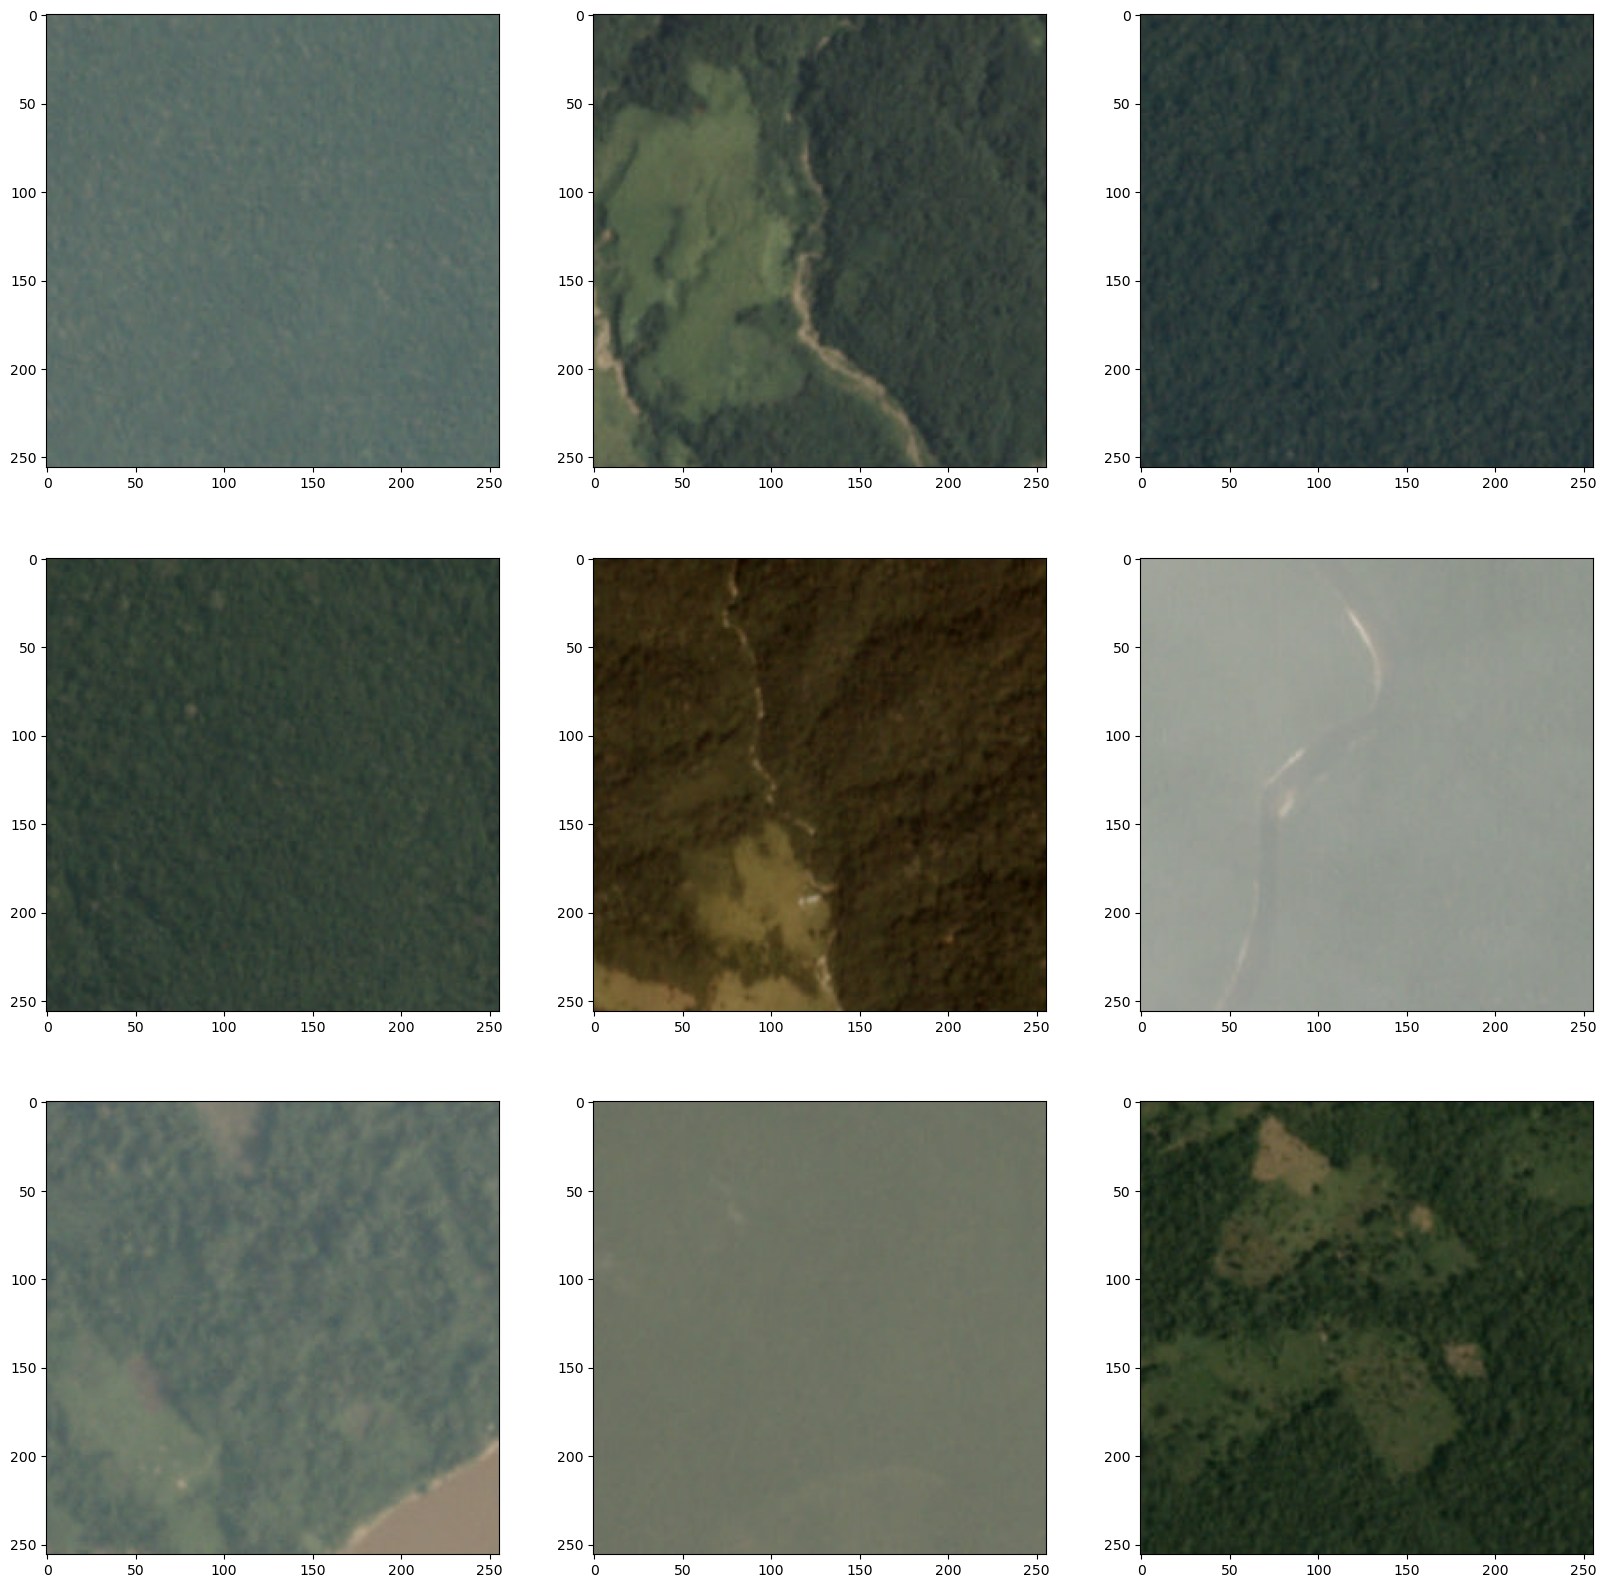

In [7]:
# Let's view some images
plt.figure(figsize=(20,20))
# define location of dataset
folder = training_image
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + 'train_' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

In [8]:
# Number of images in the dataset
print(f'Number of images: {training_df.shape[0]}')

Number of images: 40479


In [9]:
#get number of unique classes in the train dataset
training_df['tags'].nunique()

449

In [10]:
gc.collect() #Frequently used to avoid session crashing due to memory exhaustion

25566

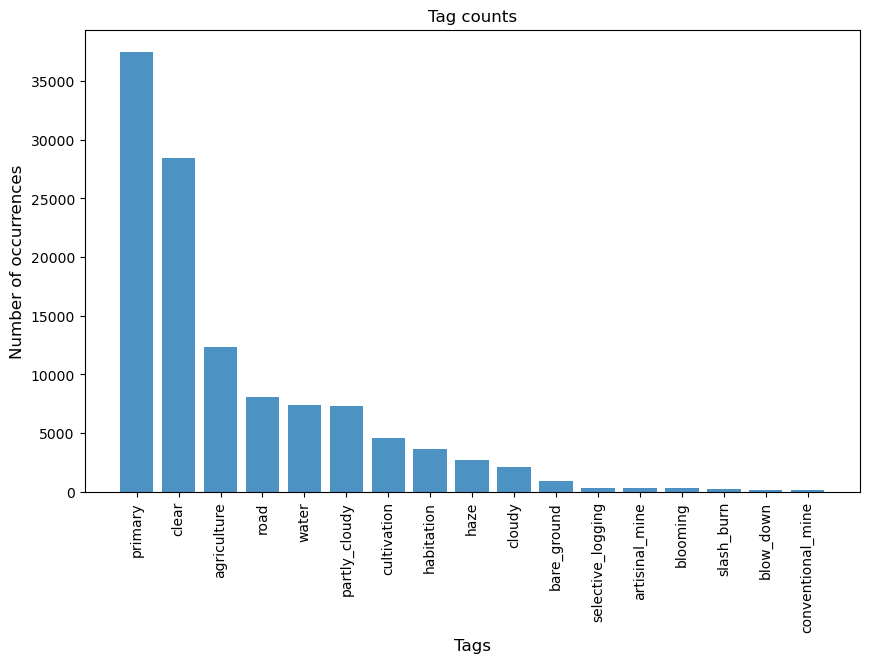

In [11]:
# Tags present in the dataset
tags = training_df['tags'].apply(lambda x: x.split(' '))
tags = [item for sublist in tags for item in sublist]
tag_counts = pd.Series(tags).value_counts()

# Plot the tags
plt.figure(figsize=(10,6))
plt.bar(tag_counts.index, tag_counts.values, alpha=0.8)
plt.title('Tag counts')
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Tags', fontsize=12)
plt.xticks(rotation=90)
plt.show();

### Preprocessing the data

In [12]:
labels = set()
def splitting_tags(tags):
    '''
    Takes in tags column, splits the tags and store as a set
    '''
    [labels.add(tag) for tag in tags.split()]
    
# Create a copy of `training_df`
training_df1 = training_df.copy()
training_df1['tags'].apply(splitting_tags)
labels = list(labels)
print(labels)

['artisinal_mine', 'water', 'conventional_mine', 'selective_logging', 'haze', 'clear', 'habitation', 'slash_burn', 'partly_cloudy', 'cultivation', 'primary', 'cloudy', 'blooming', 'bare_ground', 'agriculture', 'road', 'blow_down']


In [13]:
##One hot encoding is performed on the labels in train classes 
for tag in labels:
    training_df1[tag] = training_df1['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
## adding .jpg extension to the column image_name so as to have same name format as the image files
training_df1['image_name'] = training_df1['image_name'].apply(lambda x: '{}.jpg'.format(x))
training_df1.head()

,image_name,tags,artisinal_mine,water,conventional_mine,selective_logging,haze,clear,habitation,slash_burn,partly_cloudy,cultivation,primary,cloudy,blooming,bare_ground,agriculture,road,blow_down
0,train_0.jpg,haze primary,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
2,train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0


In [14]:
# Define the columns
columns = list(training_df1.columns[2:])
columns

['artisinal_mine',
 'water',
 'conventional_mine',
 'selective_logging',
 'haze',
 'clear',
 'habitation',
 'slash_burn',
 'partly_cloudy',
 'cultivation',
 'primary',
 'cloudy',
 'blooming',
 'bare_ground',
 'agriculture',
 'road',
 'blow_down']

In [15]:
gc.collect()

4746

In [16]:
# Initializing imagedatagenerator with a validation split of 0.2
train_datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.2)

# Generating train data generator 
train_generator = train_datagen.flow_from_dataframe(dataframe=training_df1,
                                                    directory =training_image, 
                                                    x_col='image_name', y_col=columns, subset='training', 
                                                    batch_size=32,seed=42, shuffle=True, 
                                                    class_mode='raw', target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_datagen.flow_from_dataframe(dataframe=training_df1,
                                                  directory =training_image, 
                                                  x_col='image_name', y_col=columns, subset='validation', 
                                                  batch_size=32,seed=42, shuffle=True, 
                                                  class_mode='raw', target_size=(128,128))

Found 32384 validated image filenames.

Found 8095 validated image filenames.


In [17]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [18]:
gc.collect()

42

### Modelling

In [19]:
# Define the model
def cnn_model():
    model = Sequential()

    # Convolution layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=17, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [20]:
#initialize the model
model = cnn_model()

# Preview the model architecture
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 128, 128, 32)      896       

                                                                 

 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         

 )                                                               

                                                                 

 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     

                                                                 

 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         

 2D)                                                             

                                                                 

 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     

                                                                 

 max_pooling2d_2 (MaxPooling  (None, 16,

In [21]:
# define callbacks
earlystop = EarlyStopping(monitor='val_accuracy', 
                          patience=2, verbose=1, 
                          mode='max', 
                          restore_best_weights=True)

In [22]:
gc.collect()

178

In [23]:
# Fit the model 
history = model.fit(x = train_generator, 
                    steps_per_epoch = step_train_size, 
                    validation_data = val_generator,
                    validation_steps = step_val_size,
                    epochs = 20, 
                    callbacks = [earlystop])

Epoch 1/20

1012/1012 [==============================] - 308s 289ms/step - loss: 0.2143 - accuracy: 0.0333 - val_loss: 0.1656 - val_accuracy: 0.0583

Epoch 2/20

1012/1012 [==============================] - 145s 143ms/step - loss: 0.1596 - accuracy: 0.1064 - val_loss: 0.1433 - val_accuracy: 0.1694

Epoch 3/20

1012/1012 [==============================] - 143s 141ms/step - loss: 0.1470 - accuracy: 0.1595 - val_loss: 0.1371 - val_accuracy: 0.0989

Epoch 4/20

1012/1012 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.1686Restoring model weights from the end of the best epoch: 2.

1012/1012 [==============================] - 139s 137ms/step - loss: 0.1401 - accuracy: 0.1686 - val_loss: 0.1369 - val_accuracy: 0.0994

Epoch 4: early stopping


In [24]:
gc.collect()

42

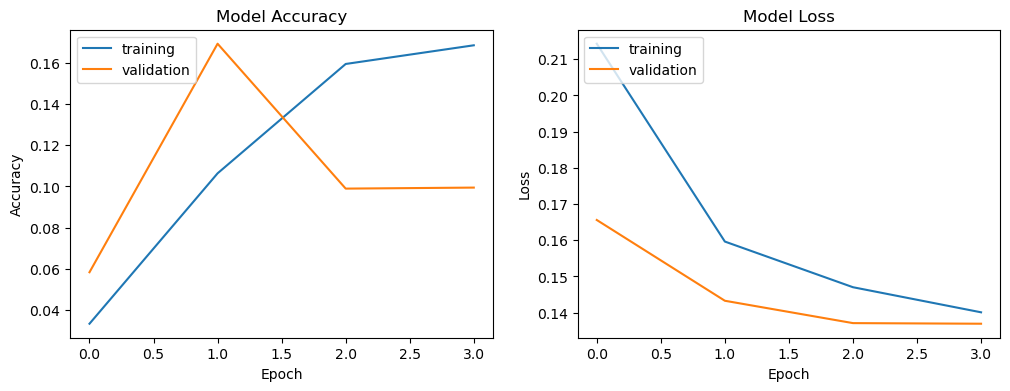

In [25]:
# Plot the training and validation accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')

plt.show()

In [26]:
gc.collect()

6865

In [27]:
#initializing a second model to make predictions
model1 = cnn_model()

In [28]:
##adding .jpg extension to image name in the sample submission file
sample_submission = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission1 = sample_submission.copy()
sample_submission1['image_name'] = sample_submission1['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [29]:
# Divide the sample submission file into two splits,
# first test1_df contains the first 40669 images 
testing_df1 = sample_submission1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
testing_df1.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [30]:
#initialize imagedatagenerator for the test images and also rescaling
test_datagen = ImageDataGenerator(rescale = 1/255)

#creating a generator for the images found in the first test image files
test_gen = test_datagen.flow_from_dataframe(dataframe=testing_df1, 
                                            directory='/kaggle/input/planets-dataset/planet/planet/test-jpg/', 
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=32,
                                            seed=42,
                                            shuffle=False, 
                                            class_mode=None, 
                                            target_size=(128,128))

step_test_size1 = int(np.ceil(test_gen.samples/test_gen.batch_size))

Found 40669 validated image filenames.


In [31]:
#first, we reset the test generator to avoid shuffling of index 
test_gen.reset()
pred = model1.predict(test_gen, steps=step_test_size1, verbose=1)

1271/1271 [==============================] - 294s 232ms/step


In [32]:
# Get the filenames in the generator using the attribute .filenames
file_names = test_gen.filenames

# Convert the predicted values to a dataframe and join two labels together if prob(occurrance of the label) > 0.5 
pred_tags = pd.DataFrame(pred)
pred_tags = pred_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names, 'tags': pred_tags})
result1.head()

,image_name,tags
0,test_0.jpg,clear slash_burn partly_cloudy blooming bare_g...
1,test_1.jpg,clear slash_burn partly_cloudy blooming bare_g...
2,test_2.jpg,selective_logging clear slash_burn partly_clou...
3,test_3.jpg,clear slash_burn partly_cloudy blooming bare_g...
4,test_4.jpg,clear slash_burn partly_cloudy blooming bare_g...


In [33]:
gc.collect()

42

In [34]:
#second batch of the test dataset
additional_df = sample_submission1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [35]:
#creating a generator for the second batch of test image files
test_gen1 = test_datagen.flow_from_dataframe(dataframe=additional_df, 
                                                directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional', 
                                                x_col='image_name', 
                                                y_col=None, 
                                                batch_size=32, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size2 = int(np.ceil(test_gen1.samples/test_gen1.batch_size))

Found 20522 validated image filenames.


In [36]:
#we reset the generator to avoid shuffling, then make prediction on the generator
test_gen1.reset()
pred1 = model1.predict(test_gen1, steps = step_test_size2, verbose = 1)

642/642 [==============================] - 149s 233ms/step


In [37]:
#this is to get the filenames in the generator using the attribute .filenames
file_names1 = test_gen1.filenames

#convert the predicted values to a dataframe
#join two labels together if the prob(occurrance of the label) > 0.5
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ''.join(np.array(labels)[x>0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result2.head()

,image_name,tags
0,file_0.jpg,clearslash_burnpartly_cloudybloomingbare_groun...
1,file_1.jpg,clearslash_burnpartly_cloudycloudybloomingbare...
2,file_10.jpg,clearslash_burnpartly_cloudycultivationbloomin...
3,file_100.jpg,clearslash_burnpartly_cloudybloomingbare_groun...
4,file_1000.jpg,clearslash_burnpartly_cloudybloomingbare_groun...


In [38]:
# Final result of the predicted tags for the test images,
# we need to concat the first and second results in 
#that order to avoid shuffling the index
final_df = pd.concat([result1, result2])

final_df = final_df.reset_index().drop('index', axis =1)

print(final_df.shape)
final_df.head()

(61191, 2)


,image_name,tags
0,test_0.jpg,clear slash_burn partly_cloudy blooming bare_g...
1,test_1.jpg,clear slash_burn partly_cloudy blooming bare_g...
2,test_2.jpg,selective_logging clear slash_burn partly_clou...
3,test_3.jpg,clear slash_burn partly_cloudy blooming bare_g...
4,test_4.jpg,clear slash_burn partly_cloudy blooming bare_g...


In [39]:
# Remove the .jpg extension from the image_name of the last_result 
final_df['image_name'] = final_df['image_name'].apply(lambda x: x[:-4])
final_df.head()

,image_name,tags
0,test_0,clear slash_burn partly_cloudy blooming bare_g...
1,test_1,clear slash_burn partly_cloudy blooming bare_g...
2,test_2,selective_logging clear slash_burn partly_clou...
3,test_3,clear slash_burn partly_cloudy blooming bare_g...
4,test_4,clear slash_burn partly_cloudy blooming bare_g...


In [40]:
# Finally, we save the result to a csv file using the .to_csv() 
# method and setting the index to false.
final_df.to_csv('submission2.csv', index = False)